## Get dataset from roboflow

In [2]:
! curl -L "https://app.roboflow.com/ds/035L0MXWQ7?key=Ar7SlkKyBk" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   914  100   914    0     0   1553      0 --:--:-- --:--:-- --:--:--  1554
 25 2962M   25  754M    0     0  16.8M      0  0:02:55  0:00:44  0:02:11 17.7M^C


In [ ]:
! mkdir data/
! cp crack\ segmentation.v3-version2.coco-segmentation.zip ./data/
! unzip crack\ segmentation.v3-version2.coco-segmentation.zip 
! rm -rf README.* crack\ segmentation.v3-version2.coco-segmentation.zip

mkdir: cannot create directory ‘data/’: File exists


## Define Coco helpers

In [2]:
from pathlib import Path
from typing import Dict, List, Any, Set
from pycocotools.coco import COCO

def load_coco(path: Path) -> COCO:

    return COCO(str(path))

def build_indices(coco: COCO):

    anns_by_image: Dict[int, List[dict]] = {}
    for img_id in coco.getImgIds():
        ann_ids = coco.getAnnIds(imgIds=img_id)
        anns_by_image[img_id] = coco.loadAnns(ann_ids)

    cats_by_id = {cat['id']: cat for cat in coco.loadCats(coco.getCatIds())}

    return anns_by_image, cats_by_id

def derive_crack_categories(cats_by_id: Dict[int, dict], crack_ids: Set[int], crack_names: Set[str]) -> Set[int]:
    resolved: Set[int] = set()
    for cid, c in cats_by_id.items():
        if cid in crack_ids:
            resolved.add(cid)
        elif str(c.get('name','')) in crack_names:
            resolved.add(cid)
    return resolved


## mask from polygon helper

In [ ]:
from typing import List
import numpy as np
import cv2

def polygons_to_mask(height: int, width: int, segmentations: List[List[float]]) -> np.ndarray:
    mask_img = np.zeros((height, width), dtype=np.uint8)
    for seg in segmentations:
        if not seg:
            continue
        
        points = np.array([(seg[i], seg[i+1]) for i in range(0, len(seg), 2)], dtype=np.int32)
        points = points.reshape((-1, 1, 2))  # Required shape for fillPoly
        cv2.fillPoly(mask_img, [points], 1)
    return mask_img


## config path and lables

In [2]:
from pathlib import Path

DATA_DIR = Path('data')
OUT_DIR  = Path('preprocessed')
INPUT_SIZE = (512, 512)

CRACK_ID_SET = {0,1,2, 3, 5, 6}
CRACK_NAME_SET = {'objects','0','Crack', 'crack', 'Crank', 'objects'}  # treat 'Crank' as alias

SCALE_IMAGES_0_1 = True
SAVE_MASKS_AS_255_VISUAL = True


## Preprocess images

In [9]:
import os
from pathlib import Path
from typing import Dict, Any
import numpy as np
import cv2


IMG_INTERP = cv2.INTER_LINEAR
MASK_INTERP = cv2.INTER_NEAREST
SPLITS = ['train', 'valid', 'test']

def ensure_dirs(base_out: Path):
    for split in SPLITS:
        for sub in ['images', 'masks', 'images_np', 'masks_np', 'viz']:
            (base_out / split / sub).mkdir(parents=True, exist_ok=True)

def process_split(split: str):
    print(f"\n==> Processing split: {split}")
    ann_path = DATA_DIR / split / "_annotations.coco.json"
    if not ann_path.exists():
        raise FileNotFoundError(f"Missing COCO json: {ann_path}")

    coco = load_coco(ann_path)
    anns_by_image, cats_by_id = build_indices(coco)
    crack_cat_ids = derive_crack_categories(cats_by_id, CRACK_ID_SET, CRACK_NAME_SET)
    print(f"Crack category IDs used for masks: {sorted(list(crack_cat_ids))}")

    img_ids = coco.getImgIds()
    images = coco.loadImgs(img_ids)

    out_split = OUT_DIR / split
    count = 0
    for img in images:
        img_id = img['id']
        fn = img['file_name']
        w, h = img['width'], img['height']
        src_path = DATA_DIR / split / fn
        if not src_path.exists():
            print(f"[WARN] Image not found, skipping: {src_path}")
            continue

        anns = anns_by_image.get(img_id, [])
        segmentations = []
        for a in anns:
            if a.get('iscrowd', 0) == 1:
                continue
            if a['category_id'] in crack_cat_ids:
                for seg in a.get('segmentation', []):
                    if isinstance(seg, list):
                        segmentations.append(seg)

        if segmentations:
            mask = polygons_to_mask(h, w, segmentations)
            mask = (mask > 0).astype(np.uint8)
        else:
            mask = np.zeros((h, w), dtype=np.uint8)

        img = cv2.imread(str(src_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

        target_h, target_w = INPUT_SIZE
        img_resized = cv2.resize(img, (target_w, target_h), interpolation=IMG_INTERP)
        mask_resized = cv2.resize(mask, (target_w, target_h), interpolation=MASK_INTERP)

        img_np = img_resized.astype(np.float32)
        if SCALE_IMAGES_0_1:
            img_np = img_np / 255.0

        (out_split / 'images').mkdir(parents=True, exist_ok=True)
        (out_split / 'masks').mkdir(parents=True, exist_ok=True)
        (out_split / 'images_np').mkdir(parents=True, exist_ok=True)
        (out_split / 'masks_np').mkdir(parents=True, exist_ok=True)

        stem = Path(fn).stem
        cv2.imwrite(str(out_split / 'images' / f"{stem}.png"), cv2.cvtColor((img_np * 255.0).clip(0,255).astype(np.uint8), cv2.COLOR_RGB2BGR))
        if SAVE_MASKS_AS_255_VISUAL:
            cv2.imwrite(str(out_split / 'masks' / f"{stem}.png"), (mask_resized * 255).astype(np.uint8))
        else:
            cv2.imwrite(str(out_split / 'masks' / f"{stem}.png"), mask_resized.astype(np.uint8))

        np.save(out_split / 'images_np' / f"{stem}.npy", img_np)
        np.save(out_split / 'masks_np' / f"{stem}.npy", mask_resized.astype(np.int64))
        count += 1

    print(f"Saved {count} samples for split '{split}'. Output -> {out_split}")

def main():
    ensure_dirs(OUT_DIR)
    for split in SPLITS:
        process_split(split)

if __name__ == '__main__':
    main()



==> Processing split: train
loading annotations into memory...
Done (t=0.07s)
creating index...
index created!
Crack category IDs used for masks: [0, 1, 2, 3, 5, 6]
Saved 2078 samples for split 'train'. Output -> preprocessed/train

==> Processing split: valid
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Crack category IDs used for masks: [0, 1, 2, 3, 5, 6]
Saved 8 samples for split 'valid'. Output -> preprocessed/valid

==> Processing split: test
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Crack category IDs used for masks: [0, 1, 2, 3, 5, 6]
Saved 27 samples for split 'test'. Output -> preprocessed/test


## Split dataset

In [10]:
! rm -rf data/train/
! rm -rf data/valid/
! rm -rf data/test/
! mkdir -p data/images_np
! mkdir -p data/masks_np
! cp preprocessed/train/images_np/* data/images_np
! cp preprocessed/train/masks_np/* data/masks_np
! cp preprocessed/valid/masks_np/* data/masks_np
! cp preprocessed/valid/masks_np/* data/masks_np
! cp preprocessed/test/masks_np/* data/masks_np
! cp preprocessed/test/masks_np/* data/masks_np

In [12]:
from pathlib import Path
import numpy as np
import shutil
import os
from sklearn.model_selection import train_test_split


def split_dataset(source_dir_path, val_size=0.10, test_size=0.05, random_state=42):

    source_dir = Path(source_dir_path)

    images_dir = source_dir / 'images_np'
    masks_dir = source_dir / 'masks_np'

    if not images_dir.exists() or not masks_dir.exists():
        raise ValueError(f"Expected directories 'images_np' and 'masks_np' in {source_dir}")

    image_files = sorted([p for p in images_dir.glob('*.npy')])
    if len(image_files) == 0:
        raise ValueError(f"No .npy files found in {images_dir}")

    train_files, temp_files = train_test_split(
        image_files, test_size=val_size + test_size, random_state=random_state
    )

    relative_test_size = test_size / (val_size + test_size)
    val_files, test_files = train_test_split(
        temp_files, test_size=relative_test_size, random_state=random_state
    )

    print(f"Splitting dataset: {len(train_files)} train, {len(val_files)} validation, {len(test_files)} test")

    splits = {
        'train': train_files,
        'val': val_files,
        'test': test_files
    }

    for split_name in splits.keys():
        split_dir = OUT_DIR / split_name
        if split_dir.exists() and split_dir != source_dir:
            response = input(f"Directory {split_dir} already exists. Overwrite? (y/n): ")
            if response.lower() != 'y':
                print(f"Skipping {split_name} split")
                del splits[split_name]

    for split_name, files in splits.items():
        split_dir = OUT_DIR / split_name
        images_split_dir = split_dir / 'images_np'
        masks_split_dir = split_dir / 'masks_np'

        os.makedirs(images_split_dir, exist_ok=True)
        os.makedirs(masks_split_dir, exist_ok=True)

        if split_dir == source_dir:
            print(f"Source and destination are the same for {split_name} split. Skipping.")
            continue

        for img_path in files:
            mask_path = masks_dir / img_path.name

            if not mask_path.exists():
                print(f"Warning: Mask not found for {img_path.name}")
                continue

            dest_img_path = images_split_dir / img_path.name
            dest_mask_path = masks_split_dir / mask_path.name

            if img_path != dest_img_path:
                shutil.copy2(img_path, dest_img_path)
            if mask_path != dest_mask_path:
                shutil.copy2(mask_path, dest_mask_path)

        print(f"Created {split_name} split with {len(files)} samples")

if __name__ == "__main__":


    source_dir = 'data'
    OUT_DIR = Path('data')
    split_dataset(source_dir)
    print("Dataset splitting complete!")


Splitting dataset: 1766 train, 208 validation, 104 test


Created train split with 1766 samples
Created val split with 208 samples
Created test split with 104 samples
Dataset splitting complete!


## Loading dataset

In [1]:
from pathlib import Path
from typing import Tuple
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
OUT_DIR = Path('data')

class CrackSegDataset(Dataset):
    def __init__(self, split: str, mean: Tuple[float,float,float]=None, std: Tuple[float,float,float]=None):
        self.split = split
        self.im_dir = OUT_DIR / split / 'images_np'
        self.mask_dir = OUT_DIR / split / 'masks_np'
        self.paths = sorted([p for p in self.im_dir.glob('*.npy')])
        self.mean = mean
        self.std = std
        if len(self.paths) == 0:
            raise RuntimeError(f"No preprocessed npy files found in {self.im_dir}. Run preprocess.py first.")

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        p = self.paths[idx]
        x = np.load(p)            # HxWx3 float32 in 0..1
        y = np.load(self.mask_dir / p.name)  # HxW int64 in {0,1}

        if self.mean is not None and self.std is not None:
            x = (x - self.mean) / self.std

        x = torch.from_numpy(x.transpose(2,0,1)).float()
        y = torch.from_numpy(y).long()
        return x, y

def make_dataloader(split: str, batch_size: int=4, shuffle: bool=True, mean=None, std=None, num_workers: int=0):
    ds = CrackSegDataset(split, mean=mean, std=std)
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)


In [14]:
train_loader = make_dataloader('train', batch_size=4, shuffle=True)
val_loader = make_dataloader('val', batch_size=4, shuffle=False)
test_loader = make_dataloader('test', batch_size=4, shuffle=False)

visualize_dataloader_samples for check

Saved visualization to _samples.png


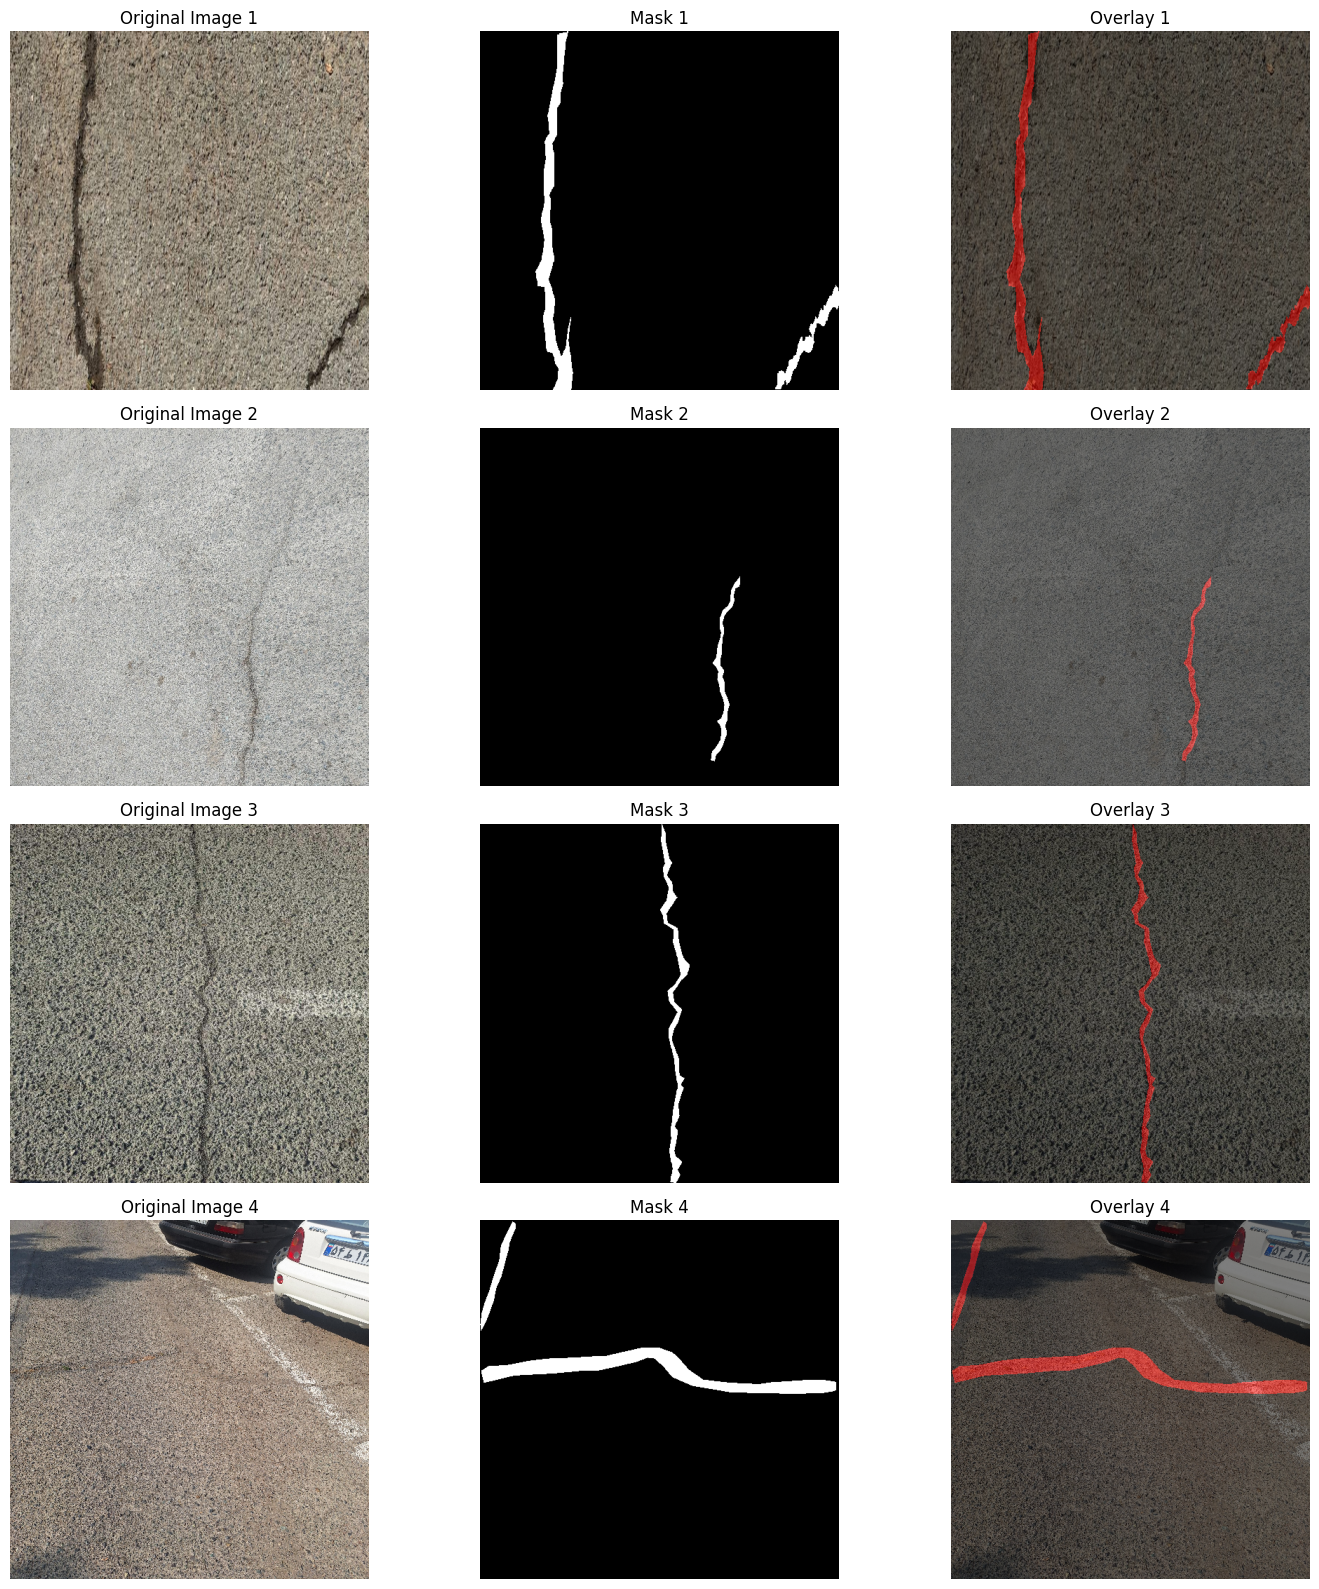

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from pathlib import Path
import os


def visualize_dataloader_samples(dataloader,num_samples =4, save_dir=None):


    images, masks = next(iter(dataloader))

    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 4*num_samples))


    if num_samples == 1:
        axes = axes.reshape(1, -1)


    for i in range(min(num_samples, len(images))):
        img = images[i].permute(1, 2, 0).numpy()  # Convert from CxHxW to HxWxC
        mask = masks[i].numpy()


        img = np.clip(img, 0, 1)


        colored_mask = np.zeros_like(img)
        colored_mask[mask == 1, 0] = 1.0

        alpha = 0.5
        blended = img * (1 - alpha) + colored_mask * alpha

        # Plot original image
        axes[i, 0].imshow(img)
        axes[i, 0].set_title(f'Original Image {i+1}')
        axes[i, 0].axis('off')

        # Plot mask
        axes[i, 1].imshow(mask, cmap='gray')
        axes[i, 1].set_title(f'Mask {i+1}')
        axes[i, 1].axis('off')

        # Plot blended image with mask overlay
        axes[i, 2].imshow(blended)
        axes[i, 2].set_title(f'Overlay {i+1}')
        axes[i, 2].axis('off')

    plt.tight_layout()

    if save_dir:
        save_path = Path(save_dir)
        os.makedirs(save_path, exist_ok=True)
        plt.savefig(save_path / '_samples.png')
        print(f"Saved visualization to {save_path / '_samples.png'}")

    plt.show()

visualize_dataloader_samples(train_loader, save_dir='.')

## Augment test data

In [3]:
import cv2
import numpy as np
from pathlib import Path
import os
import random

DATA_DIR = Path('data')
TRAIN_DIR = DATA_DIR / 'train'
TRAIN_IMAGES_NP_DIR = TRAIN_DIR / 'images_np'
TRAIN_MASKS_NP_DIR = TRAIN_DIR / 'masks_np'
AUGMENTED_IMAGES_DIR = TRAIN_DIR / 'augmented_images_np'
AUGMENTED_MASKS_DIR = TRAIN_DIR / 'augmented_masks_np'
NUM_AUGMENTATIONS = 2


def apply_augmentations(image, mask):
    
    h, w = image.shape[:2]

    # 1. Random Rotation (-30 to 30 degrees)
    angle = random.uniform(-30, 30)
    M_rot = cv2.getRotationMatrix2D((w / 2, h / 2), angle, 1)
    img_rotated = cv2.warpAffine(image, M_rot, (w, h), flags=cv2.INTER_LINEAR, borderValue=0)
    mask_rotated = cv2.warpAffine(mask, M_rot, (w, h), flags=cv2.INTER_NEAREST, borderValue=0)

    # 2. Random Scaling (0.8 to 1.2)
    scale = random.uniform(0.8, 1.2)
    M_scale = cv2.getRotationMatrix2D((w / 2, h / 2), 0, scale)
    img_scaled = cv2.warpAffine(img_rotated, M_scale, (w, h), flags=cv2.INTER_LINEAR, borderValue=0)
    mask_scaled = cv2.warpAffine(mask_rotated, M_scale, (w, h), flags=cv2.INTER_NEAREST, borderValue=0)

    # 3. Random Brightness and Contrast
    alpha = random.uniform(0.8, 1.2)  # Contrast adjustment
    beta = random.uniform(-51, 51)  # Brightness adjustment
    img_bc_adjusted = cv2.convertScaleAbs(img_scaled, alpha=alpha, beta=beta)
    img_bc_adjusted = img_bc_adjusted.astype(np.float32) / 255.0

    # 4. Add Gaussian Noise (std dev = 10)
    noise = np.zeros_like(img_bc_adjusted)
    cv2.randn(noise, 0, 10 / 255.0)
    img_noisy = np.clip(img_bc_adjusted + noise, 0, 1)

    return img_noisy, mask_scaled


def augment_and_save_dataset():
    """
    Loads original images and masks, applies augmentation, and saves the new
    augmented dataset.
    """
    os.makedirs(AUGMENTED_IMAGES_DIR, exist_ok=True)
    os.makedirs(AUGMENTED_MASKS_DIR, exist_ok=True)

    image_files = sorted(list(TRAIN_IMAGES_NP_DIR.glob('*.npy')))

    print(f"Found {len(image_files)} original training images.")
    print("Starting data augmentation...")

    for i, img_path in enumerate(image_files):
        mask_path = TRAIN_MASKS_NP_DIR / img_path.name

        if not mask_path.exists():
            print(f"Warning: Mask not found for {img_path.name}, skipping.")
            continue

        original_image = np.load(img_path)
        original_mask = np.load(mask_path)

        # Ensure mask is in the correct format for augmentation
        original_mask = original_mask.astype(np.uint8)

        # Save the original images to the augmented directory as well
        np.save(AUGMENTED_IMAGES_DIR / img_path.name, original_image)
        np.save(AUGMENTED_MASKS_DIR / mask_path.name, original_mask)

        for j in range(NUM_AUGMENTATIONS):
            aug_image, aug_mask = apply_augmentations(original_image, original_mask)

            stem = img_path.stem
            aug_img_name = f"{stem}_aug_{j}.npy"
            aug_mask_name = f"{stem}_aug_{j}.npy"

            # Save the augmented image and mask
            np.save(AUGMENTED_IMAGES_DIR / aug_img_name, aug_image)
            np.save(AUGMENTED_MASKS_DIR / aug_mask_name, aug_mask)

    total_samples = len(os.listdir(AUGMENTED_IMAGES_DIR))
    print(f"Augmentation complete. Total samples in augmented dataset: {total_samples}")


if __name__ == "__main__":
    augment_and_save_dataset()

Found 1479 original training images.
Starting data augmentation...
Augmentation complete. Total samples in augmented dataset: 4437


validate augment data

Saved visualization to _augmented_samples.png


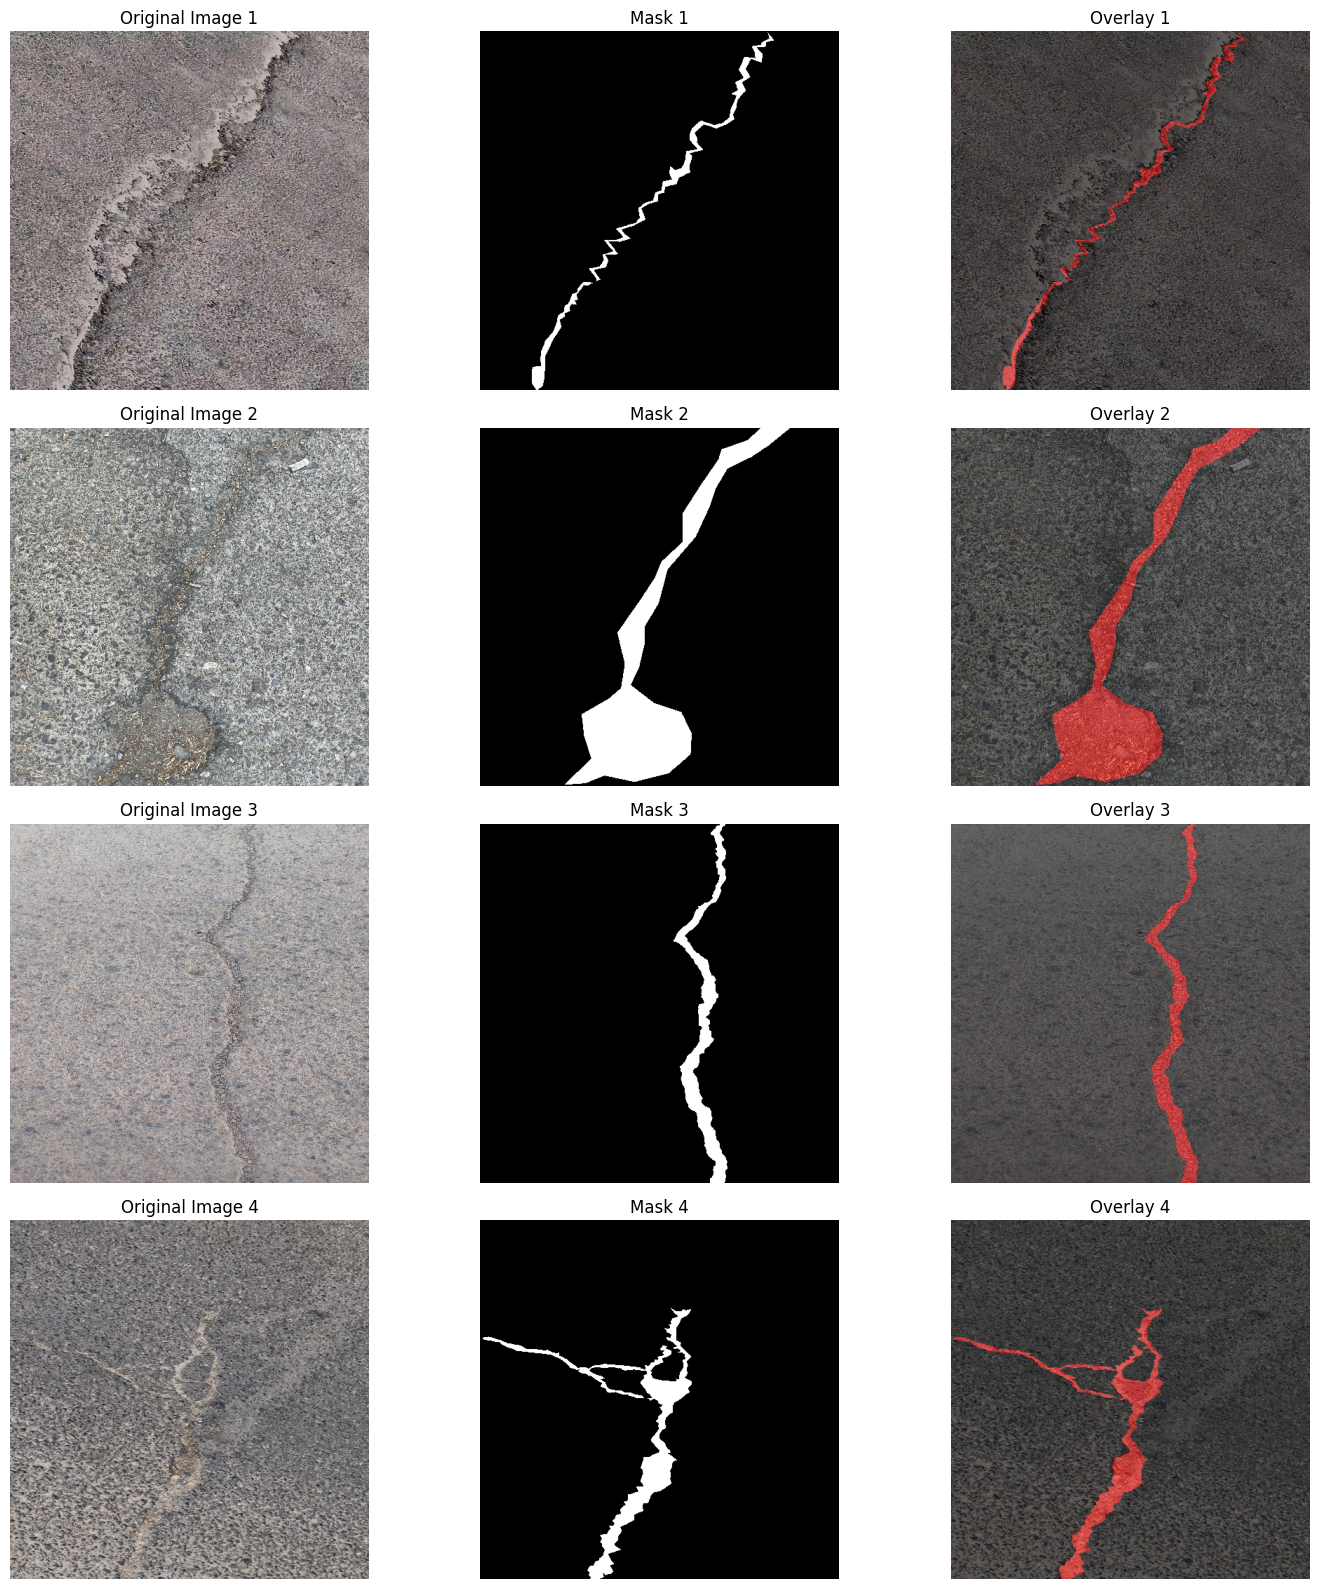

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
import os

class AugmentedCrackSegDataset(Dataset):
    def __init__(self, split: str, mean=None, std=None):
        self.split = split
        if split == 'train':
            self.im_dir = DATA_DIR / 'val' / 'augmented_images_np'
            self.mask_dir = DATA_DIR / 'val' / 'augmented_masks_np'
        else:
            self.im_dir = DATA_DIR / split / 'images_np'
            self.mask_dir = DATA_DIR / split / 'masks_np'
            
        self.paths = sorted([p for p in self.im_dir.glob('*.npy')])
        self.mean = mean
        self.std = std
        if len(self.paths) == 0:
            raise RuntimeError(f"No npy files found in {self.im_dir}. Run preprocess.py and augmentation script first.")

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        p = self.paths[idx]
        x = np.load(p)
        y = np.load(self.mask_dir / p.name)

        if self.mean is not None and self.std is not None:
            x = (x - self.mean) / self.std

        x = torch.from_numpy(x.transpose(2,0,1)).float()
        y = torch.from_numpy(y).long()
        return x, y

def make_augmented_dataloader(split: str, batch_size: int=4, shuffle: bool=True, mean=None, std=None, num_workers: int=0):
    ds = AugmentedCrackSegDataset(split, mean=mean, std=std)
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)

def visualize_dataloader_samples(dataloader, num_samples=4, save_dir=None):
    images, masks = next(iter(dataloader))
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 4 * num_samples))

    if num_samples == 1:
        axes = axes.reshape(1, -1)

    for i in range(min(num_samples, len(images))):
        img = images[i].permute(1, 2, 0).numpy()
        mask = masks[i].numpy()
        img = np.clip(img, 0, 1)

        colored_mask = np.zeros_like(img)
        colored_mask[mask == 1, 0] = 1.0

        alpha = 0.5
        blended = img * (1 - alpha) + colored_mask * alpha

        axes[i, 0].imshow(img)
        axes[i, 0].set_title(f'Original Image {i + 1}')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(mask, cmap='gray')
        axes[i, 1].set_title(f'Mask {i + 1}')
        axes[i, 1].axis('off')

        axes[i, 2].imshow(blended)
        axes[i, 2].set_title(f'Overlay {i + 1}')
        axes[i, 2].axis('off')

    plt.tight_layout()
    if save_dir:
        save_path = Path(save_dir)
        os.makedirs(save_path, exist_ok=True)
        plt.savefig(save_path / '_augmented_samples.png')
        print(f"Saved visualization to {save_path / '_augmented_samples.png'}")
    plt.show()

train_loader_augmented = make_augmented_dataloader('val', batch_size=4, shuffle=True)
visualize_dataloader_samples(train_loader_augmented, save_dir='.')